In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy.stats import linregress

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import dopioe, compute_tilt_data, bearing, ellipse_aspect_ratio, phys_grad, compute_core_mean

df_eddies = pd.read_pickle('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/df_eddies_processed_1462_10650.pkl')
df_tilt_data = pd.read_pickle("/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/Vertical_Eddy_Dataset/df_tilt_data.pkl")
df_eddies = df_eddies.merge(
    df_tilt_data[['Eddy', 'Day', 'TiltDis', 'TiltDir']],
    how='left',
    left_on=['Eddy', 'Day'],
    right_on=['Eddy', 'Day']
)
df_eddies['TiltDis_x'] = df_eddies.TiltDis * np.sin(np.deg2rad(df_eddies.TiltDir))
df_eddies['TiltDis_y'] = df_eddies.TiltDis * np.cos(np.deg2rad(df_eddies.TiltDir))
df_AE = df_eddies[df_eddies.Cyc=='AE'].copy().dropna()
df_CE = df_eddies[df_eddies.Cyc=='CE'].copy().dropna()
df_eddies


,Eddy,Day,Cyc,Lon,Lat,ic,jc,xc,yc,w,...,psi0,A,R,Age,Date,fname,TiltDis,TiltDir,TiltDis_x,TiltDis_y
0,1,1462,CE,156.969773,-28.461100,179,274,505.897600,1353.012251,-0.000033,...,71.391686,-0.006515,69.250036,57,1994-01-02,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN,NaN,NaN
1,1,1463,CE,156.993096,-28.433992,179,275,507.149717,1356.633687,-0.000030,...,77.351002,-0.006330,62.000626,57,1994-01-03,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN,NaN,NaN
2,1,1464,CE,157.097940,-28.381485,181,276,515.130000,1365.650728,-0.000028,...,75.250400,-0.005666,67.000485,57,1994-01-04,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN,NaN,NaN
3,1,1465,CE,157.094334,-28.315658,181,278,512.570772,1372.426342,-0.000033,...,72.789618,-0.005529,66.501582,57,1994-01-05,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,31.669332,89.546110,31.668338,0.250878
4,1,1466,CE,157.106324,-28.346479,181,277,514.728351,1369.599726,-0.000029,...,58.705551,-0.005821,56.251116,57,1994-01-06,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,33.600109,92.955602,33.555414,-1.732492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105233,2631,10646,AE,157.825620,-37.030656,248,97,850.502045,476.447416,0.000013,...,-41.491437,0.003143,72.751791,24,2019-02-24,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,11.563679,343.688930,-3.247684,11.098253
105234,2631,10647,AE,157.880796,-36.972725,249,98,853.608024,484.316677,0.000014,...,-42.195517,0.003373,73.000933,24,2019-02-25,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,12.848125,334.097803,-5.612527,11.557415
105235,2631,10648,AE,157.868516,-36.874363,248,100,849.759258,494.400614,0.000014,...,-43.102690,0.003752,75.750780,24,2019-02-26,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN,NaN,NaN
105236,2631,10649,AE,157.753058,-36.882303,246,99,840.037603,489.981707,0.000013,...,-37.967048,0.003769,75.750006,24,2019-02-27,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN,NaN,NaN


In [25]:
import netCDF4 as nc
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h =  np.transpose(dataset.variables['h'], axes=(1, 0))
f =  np.transpose(dataset.variables['f'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))[150, 150, :]
def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2
dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])
x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')

levels_lat = [-40, -35, -30, -25]
levels_lon = [150, 155, 160]

styles = {
    'AE': {'line': 'darkred', 'fill': 'red'},
    'CE': {'line': 'navy',    'fill': 'blue'}
}


In [26]:
def panel(ax, xcol, xlabel, legend_key, xlim=None, split=None, reg_lo_override=None,
          reg_hi_override=None, scatter=False, xlim_flag=False, ncol=2, df_data=df_eddies, zonal_TD=False, meridional_TD=False):
    df_all = df_data.dropna(subset=[xcol])
    x_min, x_max = df_all[xcol].min(), df_all[xcol].max()

    nbins = 30
    bins = np.unique(np.quantile(df_all[xcol], np.linspace(0, 1, nbins + 1)))
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    for cyc in ['AE', 'CE']:
        if zonal_TD:
            dfm = df_data[df_data.Cyc == cyc].dropna(subset=[xcol, 'TiltDis_x'])
        elif meridional_TD:
            dfm = df_data[df_data.Cyc == cyc].dropna(subset=[xcol, 'TiltDis_y'])
        else:
            dfm = df_data[df_data.Cyc == cyc].dropna(subset=[xcol, 'TiltDis'])
        if len(dfm) == 0:
            continue
        xval = dfm[xcol].values
        if zonal_TD:
            tilt = dfm['TiltDis_x'].values
        elif meridional_TD:
            tilt = dfm['TiltDis_y'].values
        else:
            tilt = dfm['TiltDis'].values

        mask = (xval >= x_min) & (xval <= x_max)
        xval, tilt = xval[mask], tilt[mask]

        d = np.digitize(xval, bins)
        med = [np.nanmedian(tilt[d == i]) for i in range(1, len(bins))]
        q25 = [np.nanquantile(tilt[d == i], .25) for i in range(1, len(bins))]
        q75 = [np.nanquantile(tilt[d == i], .75) for i in range(1, len(bins))]

        if scatter:
            ax.scatter(xval, tilt, s=1, alpha=0.08, color=styles[cyc]['fill'])

        ax.plot(bin_centers, med, lw=3, color=styles[cyc]['line'], alpha=.6)
        ax.fill_between(bin_centers, q25, q75, color=styles[cyc]['fill'], alpha=0.10)

        if split is None:
            lo, hi = np.nanpercentile(xval, [10, 90])
            mask = (xval >= lo) & (xval <= hi)
            m, c, *_ = linregress(xval[mask], tilt[mask])
            xf = np.linspace(lo, hi, 200)
            ax.plot(
                xf, m*xf + c, '--', lw=3, color=styles[cyc]['fill'],
                label=fr'{cyc}: TD={m:.3g} {legend_key} {"$-$" if c<0 else "$+$"} {abs(c):.3g}'
            )
        else:
            lo, hi = np.nanpercentile(xval, [10, 90])

            hi2 = reg_hi_override if reg_hi_override is not None else hi
            lo2 = reg_lo_override if reg_lo_override is not None else lo

            for l, (a, b) in enumerate(zip([lo2, split], [split, hi2])):
                mask = (xval >= a) & (xval <= b)
                if mask.sum() > 2:
                    m, c, *_ = linregress(xval[mask], tilt[mask])
                    xf = np.linspace(a, b, 200)
                    ax.plot(
                        xf, m*xf + c,
                        ':' if l == 0 else '--',
                        lw=3,
                        color=styles[cyc]['fill'],
                        label=fr'{cyc}: TD={m:.3g} {legend_key} {"$-$" if c<0 else "$+$"} {abs(c):.3g}'
                    )

    if xlim is None:
        ax.set_xlim(*np.nanpercentile(df_data[xcol], [10, 90]))
    else:
        ax.set_xlim(*xlim)

    if xlim_flag:
        ax.set_xlim(bin_centers.min(), bin_centers.max())

    ax.legend(loc='upper right', ncol=ncol)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)



In [27]:
ARs = []
for k in range(len(df_eddies)):
    data = df_eddies.iloc[k]
    ARs.append(ellipse_aspect_ratio(data.q11, data.q12, data.q22))
df_eddies['AR'] = ARs


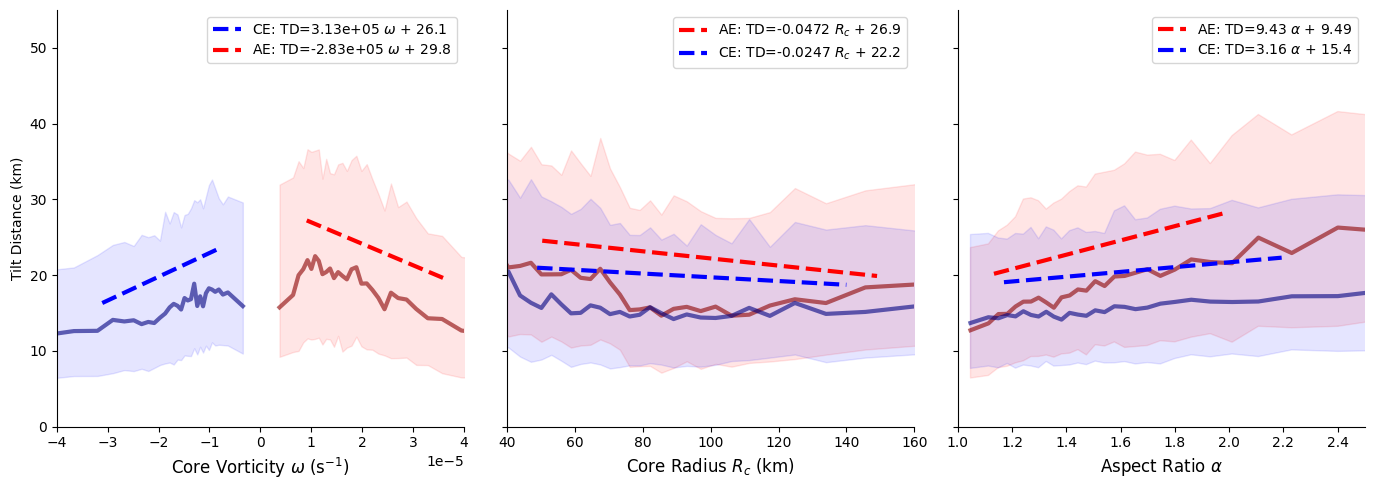

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(14, 5), sharey=True)

panel(
    axs[0],
    'w',
    r'',
    r'$\omega$',
    xlim_flag=False,
    scatter=False,
    xlim=(-4e-5, 4e-5),
    ncol=1,
    df_data=df_eddies[df_eddies.Cyc=='CE'].copy()
)
panel(
    axs[0],
    'w',
    r'Core Vorticity $\omega$ (s$^{-1}$)',
    r'$\omega$',
    xlim_flag=False,
    scatter=False,
    xlim=(-4e-5, 4e-5),
    ncol=1,
    df_data=df_eddies[df_eddies.Cyc=='AE'].copy()
)
axs[0].set_ylabel('Tilt Distance (km)')
axs[0].set_ylim(0, 55)

panel(
    axs[1],
    'Rc',
    'Core Radius $R_c$ (km)',
    r'$R_c$',
    xlim_flag=False,
    scatter=False,
    xlim=(40, 160),
    ncol=1
)
# axs[1].set_ylabel('Tilt Distance (km)')

panel(
    axs[2],
    'AR',
    r'Aspect Ratio $\alpha$',
    r'$\alpha$',
    xlim_flag=False,
    scatter=False,
    xlim=(1, 2.5),
    ncol=1
)
# axs[2].set_ylabel('Tilt Distance (km)')

plt.tight_layout()
plt.show()


In [6]:
# Nbar
df_eddies = compute_core_mean(
    df_eddies,
    X_grid, Y_grid,
    mask_rho,
    base_path="/srv/scratch/z5297792/Climatology/N2s/Nbars_300m_depth",
    varname="Nbar",
    colname="Nbar"
)


Text(0, 0.5, 'Tilt Distance (km)')

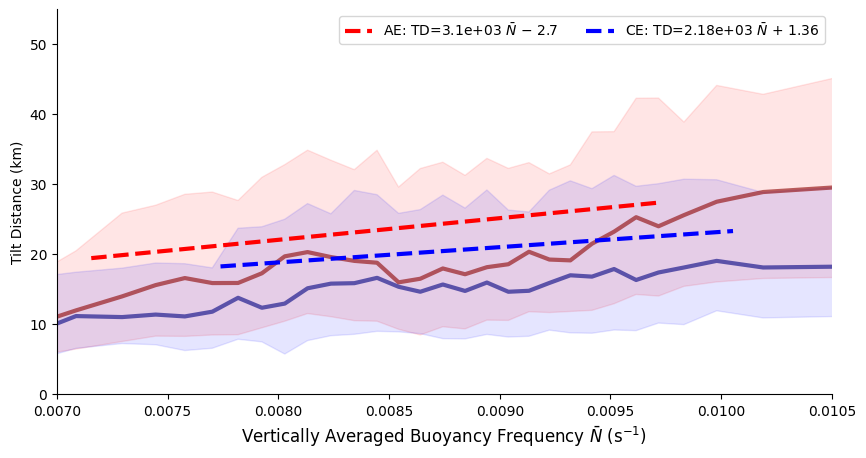

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))
panel(
    ax,
    'Nbar',
    r'Vertically Averaged Buoyancy Frequency $\bar{N}$ (s$^{-1}$)',
    r'$\bar{N}$',
    xlim_flag=False,
    scatter=False,
    xlim=(.007, .0105),
    ncol=2,
    df_data=df_eddies
)
ax.set_ylabel('Tilt Distance (km)')
ax.set_ylim(0, 55)


In [8]:
kmday_to_ms = 1000 / 86400

# --- top-centre displacements + propagation speed ---
df_eddies['dx_top'] = df_eddies.groupby('Eddy')['xc'].diff()
df_eddies['dy_top'] = df_eddies.groupby('Eddy')['yc'].diff()
df_eddies['EddyProp'] = np.hypot(df_eddies['dx_top'], df_eddies['dy_top']) * kmday_to_ms


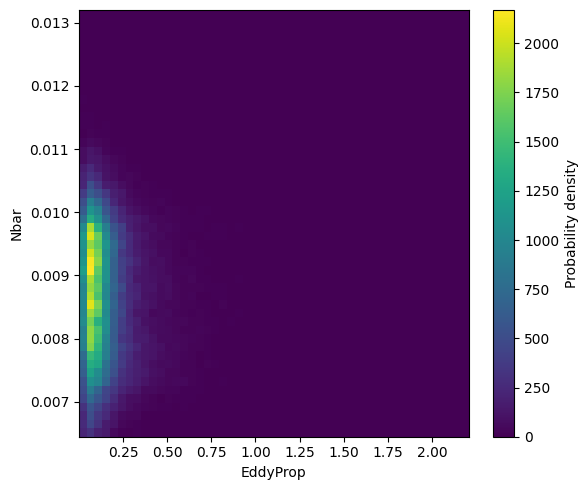

In [9]:
x = df_eddies.EddyProp
y = df_eddies.Nbar

# mask = (np.abs(x) < .2) & (np.abs(y) < .01) & (np.abs(y) > .007)
mask = (np.abs(x) < 300) & (np.abs(y) < 300)

plt.figure(figsize=(6,5))
plt.hist2d(x[mask], y[mask], bins=50, density=True)
plt.colorbar(label='Probability density')
plt.xlabel(r'EddyProp')
plt.ylabel(r'Nbar')

# plt.plot([-15,15], [-15,15], color='r', lw=.4)

plt.tight_layout()


(0.0, 55.0)

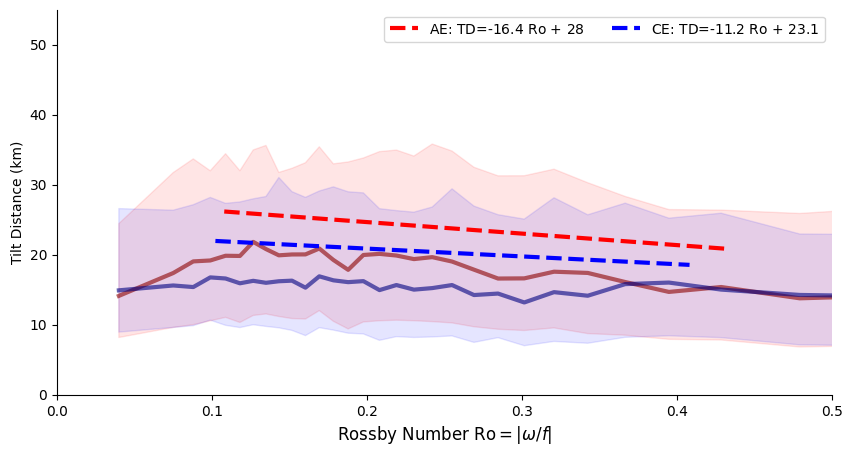

In [21]:
df_eddies['Ro'] = (df_eddies.w/f[df_eddies.ic, df_eddies.jc]).abs()

fig, ax = plt.subplots(figsize=(10, 5))
panel(
    ax,
    'Ro',
    r'Rossby Number Ro$=|\omega/f|$',
    r'Ro',
    xlim_flag=False,
    scatter=False,
    xlim=(0, .5),
    ncol=2,
    df_data=df_eddies
)
ax.set_ylabel('Tilt Distance (km)')
ax.set_ylim(0, 55)


/home/z5297792/myenv310/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/z5297792/myenv310/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:1619: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


(0.0, 55.0)

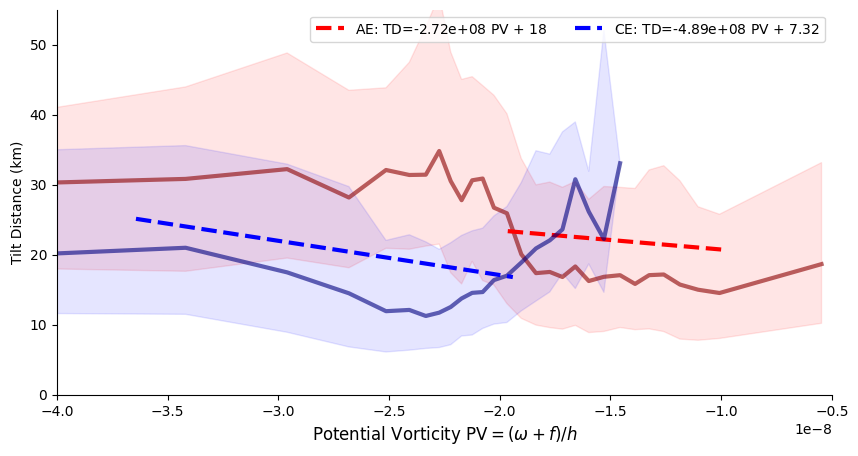

In [22]:
df_eddies['PV'] = (df_eddies.w + f[df_eddies.ic, df_eddies.jc]) / h[df_eddies.ic, df_eddies.jc]
fig, ax = plt.subplots(figsize=(10, 5))
panel(
    ax,
    'PV',
    r'Potential Vorticity PV$=(\omega+f)/h$',
    r'PV',
    xlim_flag=False,
    scatter=False,
    xlim=(-4e-8, -.5e-8),
    df_data=df_eddies
)
ax.set_ylabel('Tilt Distance (km)')
ax.set_ylim(0, 55)

## Background Flow


In [65]:
def plotter(z_lvl, df_eddies):

    u_ave = np.load('/srv/scratch/z5297792/Climatology/u_ave.npy')
    v_ave = np.load('/srv/scratch/z5297792/Climatology/v_ave.npy')

    u_ave = np.where(mask_rho[:, :, None], u_ave, np.nan)
    v_ave = np.where(mask_rho[:, :, None], v_ave, np.nan)

    if z_lvl == 'ave':
        depth_mask = np.abs(z_r) < 1000
        u_ave = np.where(depth_mask, u_ave, np.nan)
        v_ave = np.where(depth_mask, v_ave, np.nan)
        U = np.nanmean(u_ave, axis=2)
        V = np.nanmean(v_ave, axis=2)
    else:
        print(f'Depth {abs(z_r[z_lvl]):.0f}m')
        U = u_ave[:, :, z_lvl]
        V = v_ave[:, :, z_lvl]
    S = np.hypot(U, V)
    
    fig, axs = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)
    
    u_abs = min(np.abs(np.nanmin(U)), np.abs(np.nanmax(U)))
    im0 = axs[0].contourf(X_grid, Y_grid, U, cmap='coolwarm', levels=np.linspace(-u_abs, u_abs, 11), extend='both')
    v_abs = min(np.abs(np.nanmin(V)), np.abs(np.nanmax(V)))
    im1 = axs[1].contourf(X_grid, Y_grid, V, cmap='coolwarm', levels=np.linspace(-v_abs, v_abs, 11), extend='both')
    im2 = axs[2].contourf(X_grid, Y_grid, S, cmap='viridis')
    
    for ax in axs:
        ax.axis('equal')
    
    axs[0].set_title('u')
    axs[1].set_title('v')
    axs[2].set_title('speed')
    
    fig.colorbar(im0, ax=axs[0])
    fig.colorbar(im1, ax=axs[1])
    fig.colorbar(im2, ax=axs[2])

        
    df_eddies['u_lvl'] = U[df_eddies.ic, df_eddies.jc] 
    df_eddies['v_lvl'] = V[df_eddies.ic, df_eddies.jc] 
    df_eddies['CS_lvl'] = np.hypot(df_eddies.u_lvl, df_eddies.v_lvl)
    
    _, axs = plt.subplots(1, 3, figsize=(14,4))
    
    panel(
        axs[0],
        'u_lvl',
        r'u (ms$^{-1}$)',
        r'$u$',
        xlim_flag=True,
        scatter=False,
        ncol=1,
        df_data=df_eddies,
        zonal_TD=True
    )
    axs[0].set_ylabel('Zonal Tilt Distance (km)')
    
    panel(
        axs[1],
        'v_lvl',
        r'v (ms$^{-1}$)',
        r'$v$',
        xlim_flag=True,
        scatter=False,
        ncol=1,
        df_data=df_eddies,
        meridional_TD=True
    )
    axs[1].set_ylabel('Meridional Tilt Distance (km)')

    panel(
        axs[2],
        'CS_lvl',
        r'CS (ms$^{-1}$)',
        r'CS',
        xlim_flag=True,
        scatter=False,
        ncol=1,
        df_data=df_eddies
    )
    axs[2].set_ylabel('Tilt Distance (km)')
    axs[2].set_xlim(0, None)


/scratch/pbs.7455232.kman.restech.unsw.edu.au/ipykernel_3072629/613967838.py:13: RuntimeWarning: Mean of empty slice
  U = np.nanmean(u_ave, axis=2)
/scratch/pbs.7455232.kman.restech.unsw.edu.au/ipykernel_3072629/613967838.py:14: RuntimeWarning: Mean of empty slice
  V = np.nanmean(v_ave, axis=2)


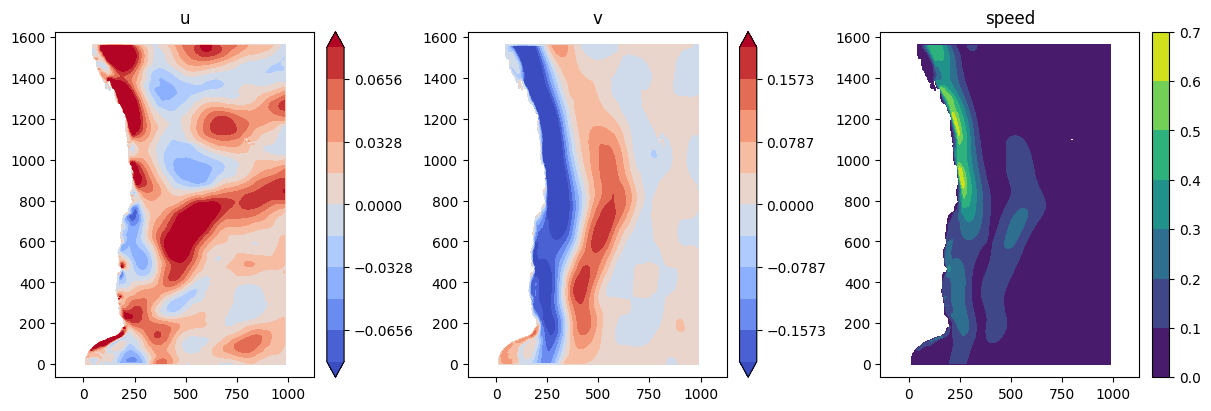

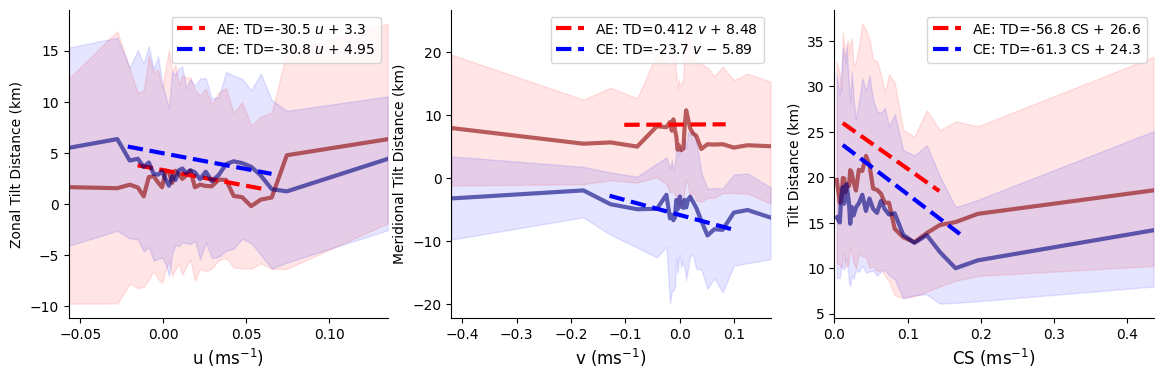

In [66]:
plotter(z_lvl='ave', df_eddies=df_eddies)


Depth 30m


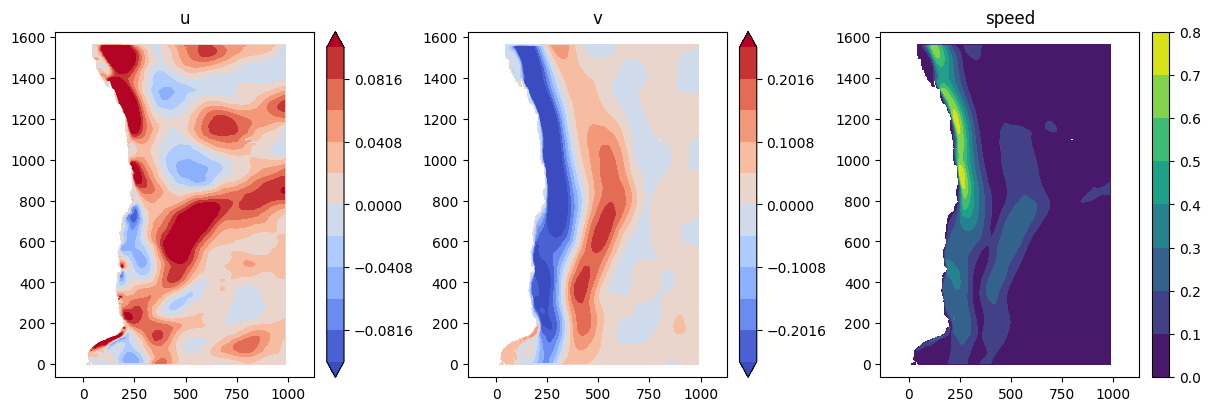

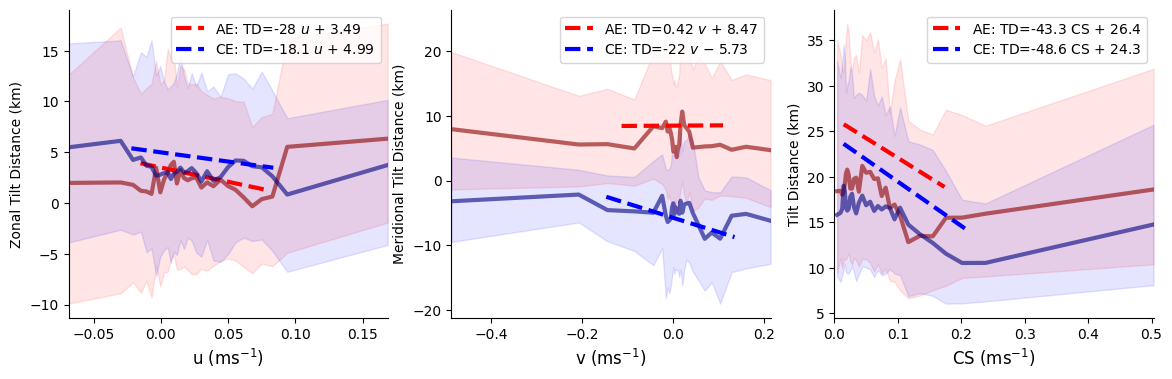

In [67]:
plotter(z_lvl=5, df_eddies=df_eddies)


Depth 859m


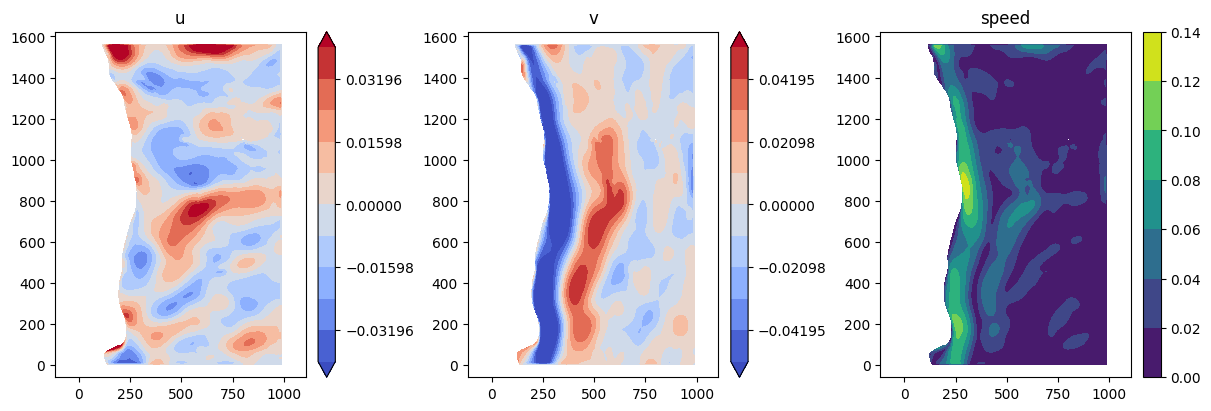

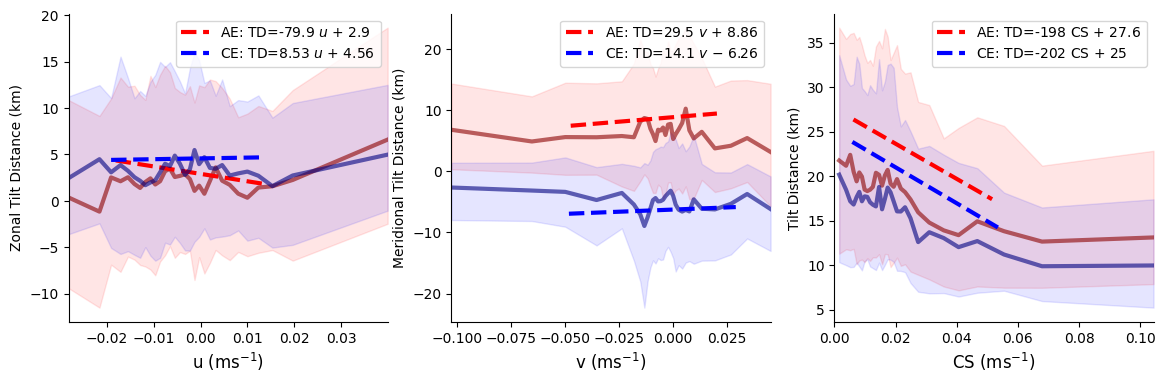

In [68]:
plotter(z_lvl=21, df_eddies=df_eddies)


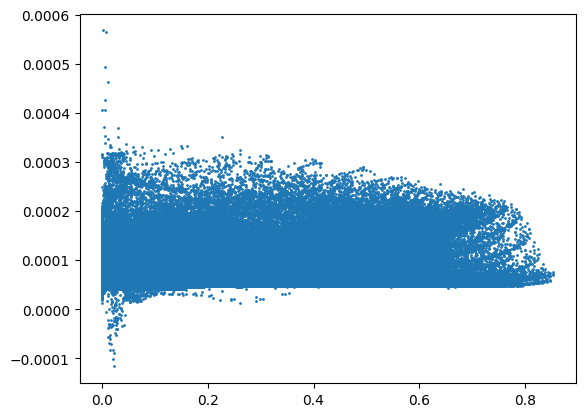

In [17]:
u_ave = np.load('/srv/scratch/z5297792/Climatology/u_ave.npy')
v_ave = np.load('/srv/scratch/z5297792/Climatology/v_ave.npy')
N2_ave = np.load('/srv/scratch/z5297792/Climatology/N2s/N2_ave.npy')

u_ave = np.where(mask_rho[:, :, None], u_ave, np.nan)
v_ave = np.where(mask_rho[:, :, None], v_ave, np.nan)

S = np.hypot(u_ave, v_ave)

plt.scatter(S.flatten(), N2_ave.flatten(), s=1)


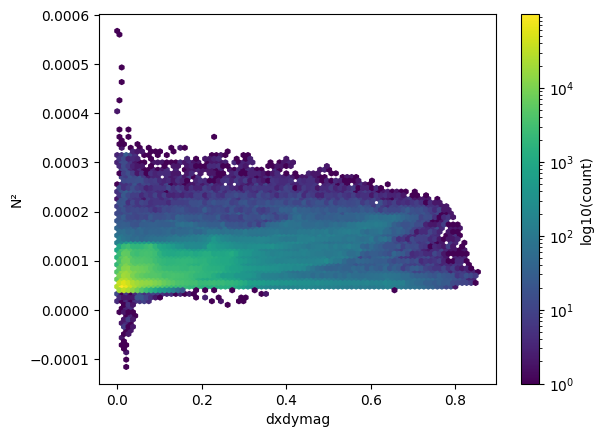

In [18]:
from scipy.stats import gaussian_kde

mag = S.flatten()
N2 = N2_ave.flatten()

m = np.isfinite(mag) & np.isfinite(N2)
mag, N2 = mag[m], N2[m]

plt.hexbin(mag, N2, gridsize=80, bins='log')
plt.xlabel("dxdymag")
plt.ylabel("N²")
plt.colorbar(label="log10(count)")
